In [ ]:
# analyze_citations.ipynb
#
# Bryan Daniels
# 8.29.2018
#
# Compare citation counts (per year) for innovative papers to the entire corpus.
#

In [1]:
%matplotlib inline
import pylab
import toolbox.defaultFigure as defaultFigure
defaultFigure.setDefaultParams()

In [3]:
import pandas as pd
import numpy as np

In [35]:
from scipy.stats import ks_2samp

In [144]:
# 8.29.2018 taken from paper-figures-rich-club.ipynb
def cdfPlot(allvalues,innovativevalues,samples=100):
    """
    samples (100)         : if given a number of samples,
                            also plot 90% confidence intervals 
                            corresponding to randomly choosing 
                            a subset of allvalues with same
                            length as innovativevalues
    """
    sortedvals = np.sort(allvalues)
    Fvals = (np.array(range(len(sortedvals)))+1)/float(len(sortedvals))

    sortedinnovativevals = np.sort(innovativevalues)
    Finnovativevals = (np.array(range(len(sortedinnovativevals)))+1)/float(len(sortedinnovativevals))
    
    if samples > 0:
        FrandomvalsAllList = []
        for i in range(samples):
            randomindices = np.random.choice(range(len(allvalues)),len(innovativevalues),replace=False)
            #Frandomvals = (np.array(range(len(randomvals)))+1)/float(len(randomvals))
            F = 0.
            FrandomvalsAll = []
            # the y-value for all unobserved points should be equal to the y-value of the closest
            # point with smaller x-value
            for idx in range(len(sortedvals)):
                if idx in randomindices:
                    F += 1./len(randomindices)
                FrandomvalsAll.append(F)
            FrandomvalsAllList.append(FrandomvalsAll)
        defaultFigure.prettyConfInt(pylab.gca(),
               sortedvals,
               np.median(FrandomvalsAllList,axis=0),
               np.percentile(FrandomvalsAllList,5,axis=0),
               np.percentile(FrandomvalsAllList,95,axis=0),color='C0',ls='')    
    
    pylab.plot(sortedvals,Fvals,label='all papers',drawstyle='steps-post')
    pylab.plot(sortedinnovativevals,Finnovativevals,label='innovative papers',drawstyle='steps-post')
    pylab.legend()
    pylab.axis(ymin=0,ymax=1)
    #pylab.ylabel('Cumulative distribution function')
    pylab.ylabel('Cumulative probability') # AKA 'Empirical distribution function'
    pylab.subplots_adjust(bottom=0.15)

In [8]:
# citation counts 
citationDataInnovative = pd.read_excel('Data/180829/InnovativePapers_Top100_Post2006_wCitations.xlsx')
citationDataAll = pd.read_excel('Data/180829/InnovativePapers_Top100_Post2006_wCitations.xlsx',sheetname=1)

In [65]:
limitYears = False #True
if limitYears:
    minYearInnovative,maxYearInnovative = 2007,2014 # to match with innovative paper years
else:
    minYearInnovative,maxYearInnovative = int(min(citationDataAll['Publication Year'])),\
                                      int(max(citationDataAll['Publication Year'])) # to use all years

citationsInnovative = citationDataInnovative['Citations per Year']\
                                [np.logical_and(citationDataInnovative['Year'] <= maxYearInnovative,
                                                citationDataInnovative['Year'] >= minYearInnovative)]
citationsAll = citationDataAll['Citations per Year']\
                                [np.logical_and(citationDataAll['Publication Year'] <= maxYearInnovative,
                                                citationDataAll['Publication Year'] >= minYearInnovative)]

In [66]:
print "There are",len(citationsInnovative),"innovative papers published between",\
        minYearInnovative,"and",maxYearInnovative
print "There are",len(citationsAll),"total papers published between",\
        minYearInnovative,"and",maxYearInnovative

There are 100 innovative papers published between 1949 and 2017
There are 9096 total papers published between 1949 and 2017


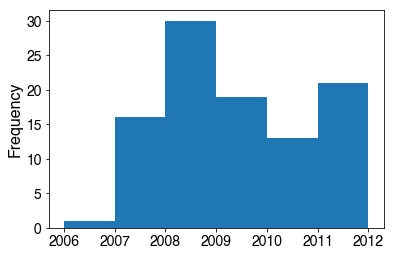

In [15]:
citationDataInnovative['Year'].plot.hist(bins=range(2006,2013))

All years
Mean citations per year for all papers (N = 9096):      10.5654679922
Mean citations per year for innovative papers (N = 100): 17.3944473304
KS test: Ks_2sampResult(statistic=0.13532981530343013, pvalue=0.04851005223201485)


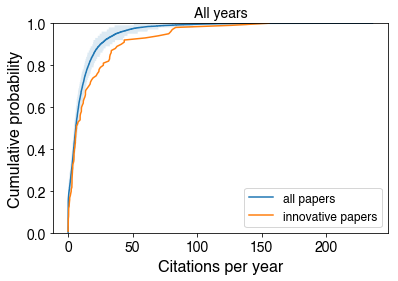

In [67]:
cdfPlot(citationsAll,citationsInnovative)
pylab.xlabel('Citations per year')
if limitYears:
    typeStr = str(minYearInnovative)+' to '+str(maxYearInnovative)
else:
    typeStr = 'All years'
pylab.title(typeStr)
pylab.legend(loc=4)
pylab.savefig('180829_citation_cumuluative_distributions_'+typeStr.replace(' ','_')+'.pdf')

print typeStr
print "Mean citations per year for all papers (N = "+str(len(citationsAll))+"):     ",np.mean(citationsAll)
print "Mean citations per year for innovative papers (N = "+str(len(citationsInnovative))+"):",\
        np.mean(citationsInnovative)
print "KS test:",ks_2samp(citationsAll,citationsInnovative)

# 9.6.2018 are there significant differences between the "core" and "periphery"?

In [82]:
# 9.6.2018 taken from paper-figures-rich-club-innovation.ipynb
def degrees(coupling):
    """
    Given coupling dataframe, return series of degrees.
    
    Edges are currently defined as sharing a nonzero number of references.
    (We throw away information about the number of shared references.)
    """
    return (coupling>0).sum(axis=1)

In [149]:
# 9.6.2018 taken from paper-figures-rich-club-innovative.ipynb

# bibliographic coupling over all years
coupling = pd.read_excel('Data/180426/Bibliographic_Coupling_Matrix.xlsx')

In [155]:
# 9.6.2018 taken from paper-figures-rich-club-innovative.ipynb

# 6.7.2018 get years for all papers.  
paperData = pd.read_excel('Data/180426/Bibliographic_Coupling_Matrix.xlsx',1)
paperData['Year'] = paperData['Title'].apply(lambda t: int(t[-5:-1]))
paperData.set_index('Name',inplace=True)
years = np.sort(paperData['Year'].unique())

# calculate bibiographic coupling to papers published anytime before the same year
couplingByYear = {}
for year in years:
    papers = list( paperData[paperData['Year'] <= year].index )
    couplingByYear[year] = coupling.loc[papers,papers]

In [211]:
# 9.6.2018 check that names match for innovative papers
for idx,name,year in zip(citationDataInnovative['ID numbers'],citationDataInnovative['First Author'],
                         citationDataInnovative['Year']):
    xlsxName = paperData.loc[idx].Title
    if not xlsxName.startswith(name) or xlsxName.find(str(year)) == -1:
        print "ID =",idx
        print "coupling XLSX:", xlsxName
        print "citation XLSX:", name, "("+str(year)+")"
        print

ID = 2810
coupling XLSX: jarrell (2010)
citation XLSX: jarrell (2011)

ID = 5685
coupling XLSX: althouse (2009)
citation XLSX: althouse (2010)

ID = 5684
coupling XLSX: althouse (2010)
citation XLSX: althouse (2009)

ID = 989
coupling XLSX: finch (2011)
citation XLSX: finch (2008)

ID = 1075
coupling XLSX: flatt (2009)
citation XLSX: flatt (2007)

ID = 1076
coupling XLSX: flatt (2009)
citation XLSX: flatt (2007)



In [92]:
# make new dataframe indexed by paper ID
citationDataInnovativeID = citationDataInnovative.set_index('ID numbers')

In [98]:
# calculate bibliographic coupling at the time of data collection
citationDataInnovativeID['bibliographic coupling'] = degrees(coupling)

In [198]:
# calculate bibliographic coupling at the year of publication
def couplingAtPublication(row):
    try:
        return degrees(couplingByYear[row['Year']]).loc[row.name]
    except:
        print "ERROR: NO COUPLING DATA FOUND"
        print "       ID =",row.name
        print "       year =",row['Year']
        print
citationDataInnovativeID['bibliographic coupling at publication'] = \
    citationDataInnovativeID.apply(couplingAtPublication,axis=1)

ERROR: NO COUPLING DATA FOUND
       ID = 5684
       year = 2009

ERROR: NO COUPLING DATA FOUND
       ID = 989
       year = 2008

ERROR: NO COUPLING DATA FOUND
       ID = 1075
       year = 2007

ERROR: NO COUPLING DATA FOUND
       ID = 1076
       year = 2007



In [200]:
citationDataInnovativeID.head()

,First Author,Year,Citations,Unnamed: 4,Years since 2018,Citations per Year,Unnamed: 7,Average Citations Per Year,bibliographic coupling,bibliographic coupling at publication
ID numbers,,,,,,,,,,
985,crimmins,2012,27,NaN,6,4.500000,NaN,17.394447,47,32.0
3505,eizaguirre,2012,109,NaN,6,18.166667,NaN,NaN,159,92.0
4976,ruths,2012,46,NaN,6,7.666667,NaN,NaN,61,30.0
3506,eizaguirre,2012,78,NaN,6,13.000000,NaN,NaN,102,57.0
226,keller,2012,74,NaN,6,12.333333,NaN,NaN,2,1.0


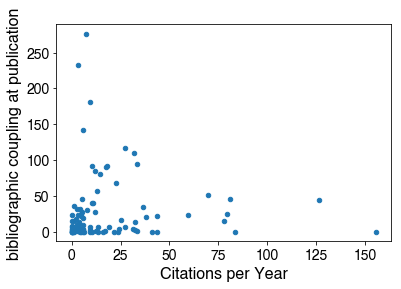

In [201]:
citationDataInnovativeID.plot.scatter('Citations per Year','bibliographic coupling at publication')

In [202]:
# is there a significant spearman correlation between citations and coupling in innovative papers? No
scipy.stats.spearmanr(citationDataInnovativeID['Citations per Year'],
                      citationDataInnovativeID['bibliographic coupling at publication'])

SpearmanrResult(correlation=nan, pvalue=nan)

In [127]:
# is there a significant pearson correlation between citations and coupling in innovative papers? No
scipy.stats.pearsonr(citationDataInnovativeID['Citations per Year'],
                     citationDataInnovativeID['bibliographic coupling'])

(-0.025066766537090217, 0.8044786990308291)

Median bibliographic coupling at publication = 7.0


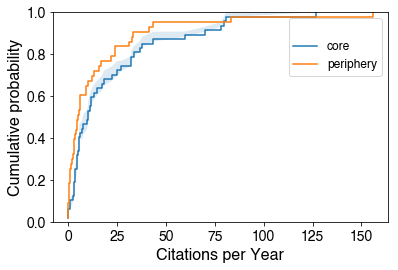

In [204]:
# is there a significant difference in citations between high- and low-coupling innovative papers?
# (split at the median coupling)
medianCoupling = citationDataInnovativeID['bibliographic coupling at publication'].median()
print "Median bibliographic coupling at publication =",medianCoupling
periphery = citationDataInnovativeID['bibliographic coupling at publication'] < medianCoupling
core = citationDataInnovativeID['bibliographic coupling at publication'] > medianCoupling
citationsPeriphery = citationDataInnovativeID.loc[periphery]['Citations per Year']
citationsCore = citationDataInnovativeID.loc[core]['Citations per Year']

cdfPlot(citationsCore,citationsPeriphery)
pylab.xlabel('Citations per Year')
pylab.legend(['','core','periphery'])

Coupling cutoff = 2


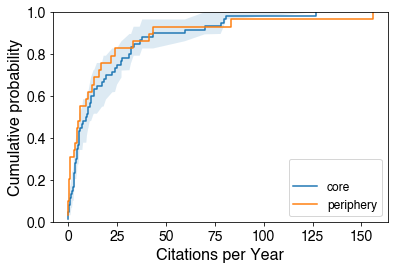

In [209]:
# is there a significant difference in citations between high- and low-coupling innovative papers?
# (split at 10)
couplingCutoff = 2
print "Coupling cutoff =",couplingCutoff
periphery = citationDataInnovativeID['bibliographic coupling at publication'] < couplingCutoff
core = citationDataInnovativeID['bibliographic coupling at publication'] > couplingCutoff
citationsPeriphery = citationDataInnovativeID.loc[periphery]['Citations per Year']
citationsCore = citationDataInnovativeID.loc[core]['Citations per Year']

cdfPlot(citationsCore,citationsPeriphery)
pylab.xlabel('Citations per Year')
pylab.legend(['','core','periphery'],loc=4)

In [210]:
citationDataInnovativeID.loc[citationDataInnovativeID['Citations per Year']>100]

,First Author,Year,Citations,Unnamed: 4,Years since 2018,Citations per Year,Unnamed: 7,Average Citations Per Year,bibliographic coupling,bibliographic coupling at publication
ID numbers,,,,,,,,,,
41,carlsson,2012,760,NaN,6,126.666667,NaN,NaN,63,44.0
4778,zhang,2009,1401,NaN,9,155.666667,NaN,NaN,1,0.0
